In [40]:
import sys
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

sys.path.append("..")
import geoobb.obb as obb

## Load data


In [13]:
api_url = r'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/MAPPLUTO/FeatureServer/0/query'

params = {
    'where': 'CD = 111',
    'f': 'pgeojson'
}

r = requests.get(api_url, params=params)

gdf = gpd.read_file(r.text)
gdf.to_crs(epsg=2263, inplace=True)

# the api has a max record limit of 4000
print(f'{len(gdf)} records returned')

3082 records returned


In [11]:
def bounds_to_polygon(minx, miny, maxx, maxy):
    return Polygon([
        (minx, miny),
        (minx, maxy),
        (maxx, maxy),
        (maxx, miny),
        (minx, miny)
    ])

bounds_polys = gpd.GeoSeries(gdf.geometry.bounds.apply(lambda x: bounds_to_polygon(*x.values), axis=1), crs=gdf.crs)

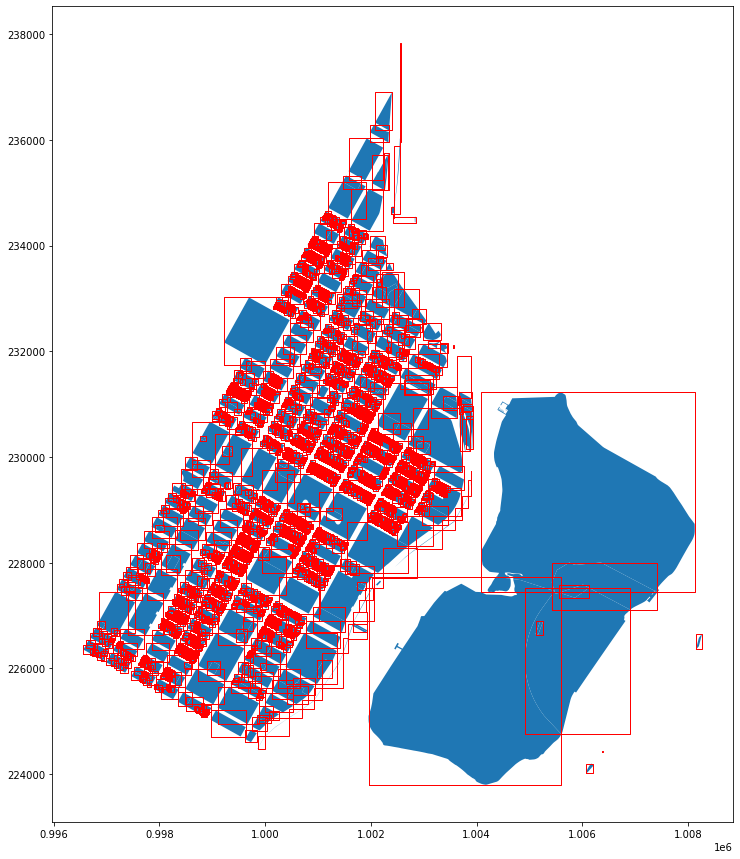

In [14]:
ax = gdf.plot(figsize=(15, 15));
bounds_polys.plot(ax=ax, linewidth=1, edgecolor='red', facecolor='none');

## Bounding box compactness


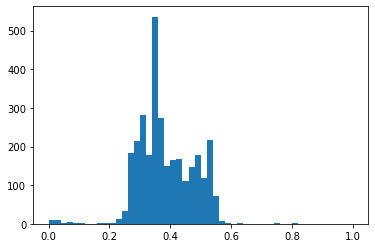

In [17]:
step = 0.02
plt.hist(gdf.area / bounds_polys.area, bins=np.arange(0, 1 + step, step));

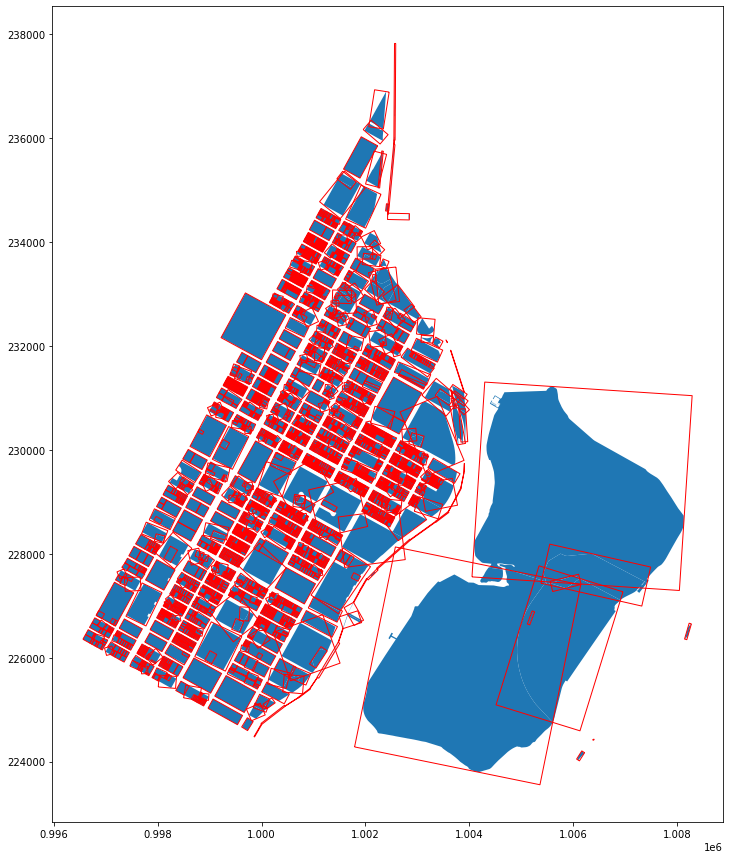

In [18]:
convex_hull_arrs = gdf.geometry.convex_hull.map(obb.geom_to_array)
obbs = convex_hull_arrs.apply(obb.oriented_bounding_box)

obbs_gs = gpd.GeoSeries(obbs.map(obb.polygon_from_obb), crs=gdf.crs)
ax = gdf.plot(figsize=(15, 15))
obbs_gs.plot(ax=ax, linewidth=1, edgecolor='red', facecolor='none');

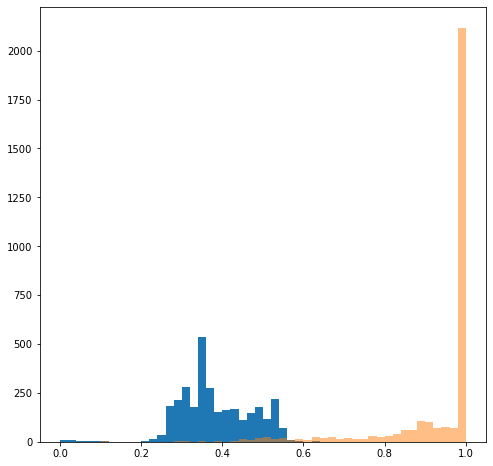

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))

step = 0.02
ax.hist(gdf.area / bounds_polys.area, bins=np.arange(0, 1 + step, step), label='Bounds');
ax.hist(gdf.area / obbs_gs.area, bins=np.arange(0, 1 + step, step), alpha=0.5, label='OBB');

plt.show();

In [41]:
obb_dims = convex_hull_arrs.apply(obb.oriented_bounding_box_dimensions)
obb_dims = pd.DataFrame(obb_dims.to_list(), columns=['width', 'height'])

In [42]:
obb_dims['aspect_ratio'] = obb_dims['width'] / obb_dims['height']

In [ ]:
# use log scale to better see the distribution
obb_dims['aspect_ratio'].hist(bins=100, log=True);

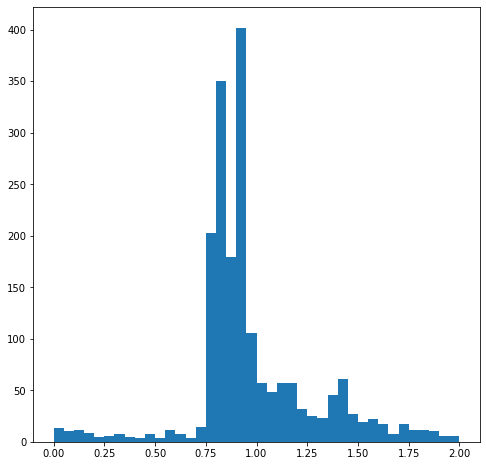

In [49]:
fig, ax = plt.subplots(figsize=(8, 8))

step = 0.05
ax.hist(obb_dims['aspect_ratio'], label='Aspect Ratio', bins=np.arange(0, 2 + step, step));

plt.show();

AR not really a measure of compactness, since it's not relative to the actual geom. But it is a measure of longy-ness.


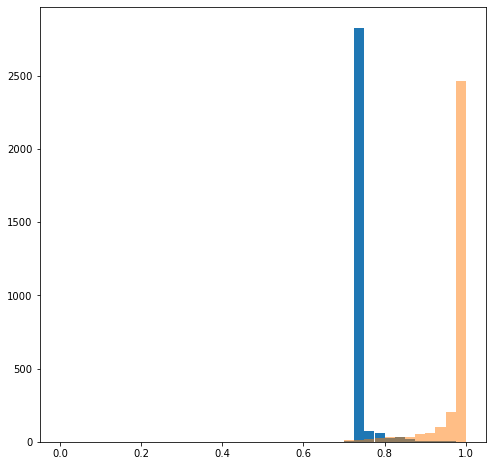

In [55]:
fig, ax = plt.subplots(figsize=(8, 8))

step = 0.025
plt.hist(gdf.geometry.length / bounds_polys.length, bins=np.arange(0, 1 + step, step), label='Bounds');
plt.hist(gdf.geometry.length / obbs_gs.length, bins=np.arange(0, 1 + step, step), alpha=0.5, label='OBB');
plt.show();